# Time Series Foundations for Empirical Asset Pricing

## Why Returns Are Not Just "Data Points" — Stationarity, Dependence, and What It Takes to Do Valid Inference on Financial Time Series

---

### Where This Fits

The **Statistical Foundations Tutorial** established the general machinery: CLT, hypothesis testing, OLS, and Newey-West standard errors. But it worked mostly with generic i.i.d. data or tiny hand-checkable examples.

Financial returns are **time series** — ordered sequences of observations where the timestamp matters. This introduces specific challenges that cross-sectional statistics ignores:

- **Stationarity**: Are the statistical properties of returns constant over time, or do they drift?
- **Autocorrelation**: Does today's return predict tomorrow's?
- **Volatility clustering**: Do calm and turbulent periods come in clusters?
- **Ergodicity**: Can we learn population parameters from a single time path?

This notebook makes those concepts concrete with **real Fama-French factor data**, so that when you encounter them in the 3-Factor and Advanced tutorials, you will understand *why* Newey-West is needed and *what assumptions* your regressions actually rest on.

### Recommended Reading Order

1. `01_Statistical_Foundations.ipynb` — general statistics and Newey-West
2. **`02_Time_Series_Foundations.ipynb`** — this notebook
3. `03_Fama_French_3Factor.ipynb` — applying the models
4. `04_Advanced_Factor_Models.ipynb` — extensions and research frontier

### What We'll Cover

| Section | Topic | Key Concept |
|---------|-------|-------------|
| 1 | Prices vs. Returns | Why we work with returns, not prices |
| 2 | Stationarity | Weak stationarity, why it matters, testing for it |
| 3 | Autocorrelation | ACF, PACF, Ljung-Box test, what predictability means |
| 4 | Volatility Clustering | ARCH effects, conditional heteroscedasticity |
| 5 | Ergodicity & Mixing | Why a single time path can teach us about the population |
| 6 | Summary of Assumptions | What Fama-French regressions actually require |

### Prerequisites

- The Statistical Foundations Tutorial (Sections 1–5 especially)
- Basic Python / NumPy / Matplotlib

In [12]:
# ============================================================================
# Setup: Import libraries and download Fama-French factor data
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import urllib.request
import zipfile
import tempfile
import os
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('default')

np.random.seed(42)

# Download Fama-French 3-Factor data from Ken French's library
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"

with tempfile.TemporaryDirectory() as tmpdir:
    zip_path = f"{tmpdir}/ff_data.zip"
    urllib.request.urlretrieve(url, zip_path)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(tmpdir)

    files = os.listdir(tmpdir)
    csv_file = None
    for f in files:
        if f.lower().endswith('.csv'):
            csv_file = f"{tmpdir}/{f}"
            break

    if not csv_file:
        raise ValueError(f"No CSV file found. Files: {files}")

    ff3 = pd.read_csv(csv_file, skiprows=4, index_col=0)

# Clean up: keep only monthly rows (6-digit YYYYMM index)
ff3.index = pd.Index(ff3.index.astype(str).str.strip())
ff3 = ff3[ff3.index.str.match(r'^\d{6}$')]
ff3.index = pd.to_datetime(ff3.index, format='%Y%m')
ff3 = ff3.apply(pd.to_numeric, errors='coerce').dropna()
ff3.columns = ['Mkt-RF', 'SMB', 'HML', 'RF']
ff3 = ff3.loc['2000-01-01':'2023-12-31']
ff3 = ff3 / 100  # Convert from percent to decimal

print(f"Fama-French 3-Factor data loaded: {len(ff3)} months")
print(f"Period: {ff3.index[0].strftime('%Y-%m')} to {ff3.index[-1].strftime('%Y-%m')}")
print(f"\nColumns: {list(ff3.columns)}")
print(f"\nFirst 5 rows:")
print(ff3.head())

Fama-French 3-Factor data loaded: 288 months
Period: 2000-01 to 2023-12

Columns: ['Mkt-RF', 'SMB', 'HML', 'RF']

First 5 rows:
            Mkt-RF     SMB     HML      RF
2000-01-01 -0.0474  0.0516 -0.0112  0.0041
2000-02-01  0.0246  0.2125 -0.0977  0.0043
2000-03-01  0.0521 -0.1741  0.0850  0.0047
2000-04-01 -0.0639 -0.0600  0.0645  0.0046
2000-05-01 -0.0439 -0.0608  0.0459  0.0050


---

## Section 1: Prices vs. Returns — Why We Transform the Data

### 1.1 The Problem with Prices

Stock prices are what we observe in the market, but they are **terrible** for statistical analysis. Consider the S&P 500 index from 2000 to 2023: it started around 1,400, fell below 800 during the dot-com bust, recovered above 1,500 by 2007, crashed below 700 in the 2008–09 financial crisis, climbed past 3,000 by 2019, plunged briefly to 2,200 in the COVID sell-off, and ended 2023 near 4,800. The *level* of the price changes dramatically — the variance of daily prices in 2020 (around 3,000) is vastly larger than in 2003 (around 1,000), simply because the price itself is bigger.

More formally, stock prices are a **non-stationary** process: their mean and variance change systematically over time. The early statistical tools we developed — sample mean, sample variance, the CLT — all assume (or require) some form of **stationarity**.

### 1.2 The Solution: Returns

The **simple return** over one period is:

$$R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1$$

The **log return** (continuously compounded return) is:

$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) = \ln(P_t) - \ln(P_{t-1})$$

For small returns, $R_t \approx r_t$ (by the Taylor expansion $\ln(1+x) \approx x$). The Fama-French factors are reported as simple returns.

**Why returns fix the problem:**

- Returns are *scale-free*: a 2% return in 2003 and a 2% return in 2023 are directly comparable, even though the price levels differ by a factor of 5.
- Returns are (approximately) **stationary**: their statistical properties — mean, variance, autocorrelation — are roughly constant over time. This is the key assumption we need.
- Log returns are **additive**: the multi-period log return is $r_{t:t+k} = r_t + r_{t+1} + \cdots + r_{t+k}$. This makes aggregation clean.

### 1.3 Excess Returns

In asset pricing, we typically work with **excess returns**:

$$R^e_t = R_t - R^f_t$$

where $R^f_t$ is the risk-free rate (e.g., 1-month Treasury bill rate). This is what the Fama-French factors represent: Mkt-RF is the market *excess* return.

Excess returns strip out the compensation for the time value of money, isolating the **risk premium** — which is what we want to test and measure.

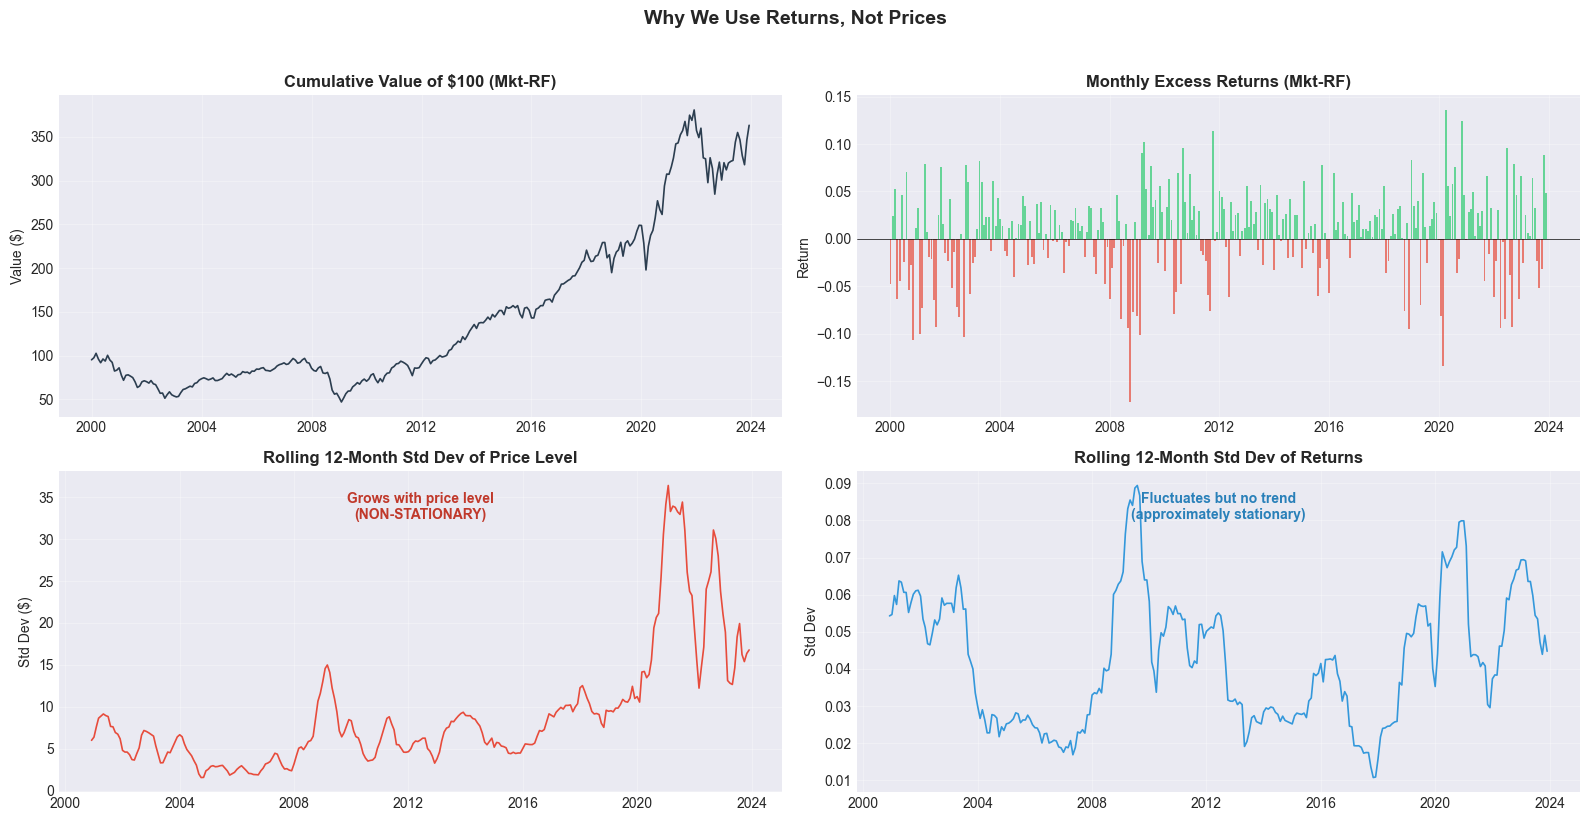

KEY INSIGHT: The price level's volatility grows over time (non-stationary),
while return volatility fluctuates around a roughly constant level (stationary).
This is why all of financial econometrics works with returns, not prices.


In [13]:
# ============================================================================
# Section 1: Prices vs. Returns — Visual demonstration
# ============================================================================

# Construct a cumulative "price" series from the market excess returns
mkt = ff3['Mkt-RF']
cumulative_price = (1 + mkt).cumprod() * 100  # Start at 100

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# --- Top left: Cumulative "price" level ---
ax = axes[0, 0]
ax.plot(cumulative_price.index, cumulative_price.values, color='#2c3e50', linewidth=1.2)
ax.set_title('Cumulative Value of $100 (Mkt-RF)', fontweight='bold', fontsize=12)
ax.set_ylabel('Value ($)')
ax.grid(True, alpha=0.3)

# --- Top right: Monthly returns ---
ax = axes[0, 1]
ax.bar(mkt.index, mkt.values, color=np.where(mkt >= 0, '#2ecc71', '#e74c3c'), width=25, alpha=0.7)
ax.set_title('Monthly Excess Returns (Mkt-RF)', fontweight='bold', fontsize=12)
ax.set_ylabel('Return')
ax.axhline(y=0, color='black', linewidth=0.5)
ax.grid(True, alpha=0.3)

# --- Bottom left: Rolling 12-month std of cumulative value ---
ax = axes[1, 0]
rolling_price_std = cumulative_price.rolling(12).std()
ax.plot(rolling_price_std.index, rolling_price_std.values, color='#e74c3c', linewidth=1.2)
ax.set_title('Rolling 12-Month Std Dev of Price Level', fontweight='bold', fontsize=12)
ax.set_ylabel('Std Dev ($)')
ax.grid(True, alpha=0.3)
ax.annotate('Grows with price level\n(NON-STATIONARY)', xy=(0.5, 0.85),
            xycoords='axes fraction', ha='center', fontsize=10, color='#c0392b', fontweight='bold')

# --- Bottom right: Rolling 12-month std of returns ---
ax = axes[1, 1]
rolling_ret_std = mkt.rolling(12).std()
ax.plot(rolling_ret_std.index, rolling_ret_std.values, color='#3498db', linewidth=1.2)
ax.set_title('Rolling 12-Month Std Dev of Returns', fontweight='bold', fontsize=12)
ax.set_ylabel('Std Dev')
ax.grid(True, alpha=0.3)
ax.annotate('Fluctuates but no trend\n(approximately stationary)', xy=(0.5, 0.85),
            xycoords='axes fraction', ha='center', fontsize=10, color='#2980b9', fontweight='bold')

fig.suptitle('Why We Use Returns, Not Prices', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("KEY INSIGHT: The price level's volatility grows over time (non-stationary),")
print("while return volatility fluctuates around a roughly constant level (stationary).")
print("This is why all of financial econometrics works with returns, not prices.")

---

## Section 2: Stationarity — The Foundation of Time Series Inference

### 2.1 What Is Stationarity?

A time series $\{X_t\}$ is (weakly / covariance) **stationary** if:

1. **Constant mean**: $E[X_t] = \mu$ for all $t$
2. **Constant variance**: $\text{Var}(X_t) = \gamma_0$ for all $t$
3. **Autocovariance depends only on lag**: $\text{Cov}(X_t, X_{t+k}) = \gamma_k$ for all $t$

In words: the statistical properties of the process do not change depending on *when* you observe it. A stationary process "looks the same" whether you examine it in 2005 or 2019.

There is also a stronger notion — **strict (strong) stationarity** — which requires that the entire joint distribution of $(X_{t_1}, \ldots, X_{t_k})$ is invariant to time shifts. For most financial applications, weak stationarity is sufficient.

### 2.2 Why Stationarity Matters

Stationarity is not just a mathematical nicety — it is **essential** for inference:

| What we want to do | Why stationarity is needed |
|---------------------|---------------------------|
| Estimate a mean $\mu$ | If $E[X_t]$ changes over time, "the mean" is not well-defined. $\bar{X}_n$ estimates... what? |
| Estimate a variance $\sigma^2$ | If $\text{Var}(X_t)$ drifts, the sample variance does not converge to anything meaningful |
| Apply the CLT | All CLT versions (Section 3 of the Foundations tutorial) require stationarity (or something close to it) for the sample mean to converge |
| Run a regression | OLS assumes the coefficients $\beta$ are *constant*. If the relationship between $y$ and $x$ changes over time, $\hat{\beta}$ is an average of a moving target |
| Use Newey-West | The autocovariance structure $\gamma_k$ must be constant over time; otherwise the HAC estimator has no fixed target |

**The bottom line:** Nearly every statistical tool we use in the Fama-French tutorials implicitly assumes stationarity of returns. If returns were non-stationary, our regressions, t-statistics, and p-values would be meaningless.

### 2.3 Are Stock Returns Stationary?

**Approximately, yes** — and this is why financial econometrics works at all.

- **Prices** are non-stationary (they trend, they have unit roots).
- **Returns** are approximately stationary: their mean and autocovariance structure are roughly constant over long periods.

The qualification "approximately" is important:

- Volatility is *not* perfectly constant — it clusters (Section 4). But the *unconditional* variance $\text{Var}(X_t)$ can still be constant even if the *conditional* variance $\text{Var}(X_t \mid X_{t-1}, \ldots)$ fluctuates (this is the GARCH framework).
- The mean return may shift slowly over very long horizons (structural breaks, changing risk premia). For the 10–25 year windows typical in Fama-French studies, this is usually negligible.

### 2.4 Testing for Stationarity: The Augmented Dickey-Fuller Test

The **Augmented Dickey-Fuller (ADF) test** is the standard tool for detecting non-stationarity. It tests:

- $H_0$: The series has a **unit root** (non-stationary — behaves like a random walk)
- $H_1$: The series is **stationary**

The test fits a regression:

$$\Delta X_t = \delta X_{t-1} + \sum_{j=1}^{p} \phi_j \Delta X_{t-j} + \epsilon_t$$

and tests $H_0: \delta = 0$ (unit root) vs. $H_1: \delta < 0$ (stationary / mean-reverting).

If the $p$-value is small, we reject the null of a unit root and conclude the series is stationary.

In [14]:
# ============================================================================
# Section 2: Stationarity tests — prices vs. returns
# ============================================================================

print("AUGMENTED DICKEY-FULLER TESTS FOR STATIONARITY")
print("=" * 65)
print(f"{'Series':<30} {'ADF Stat':>10} {'p-value':>10} {'Stationary?':>14}")
print("-" * 65)

# Test the cumulative "price" series
adf_price = adfuller(cumulative_price.dropna(), autolag='AIC')
print(f"{'Cumulative price level':<30} {adf_price[0]:>10.4f} {adf_price[1]:>10.4f} {'NO' if adf_price[1] > 0.05 else 'YES':>14}")

# Test each factor's returns
for col in ['Mkt-RF', 'SMB', 'HML']:
    adf_result = adfuller(ff3[col].dropna(), autolag='AIC')
    stationary = 'YES' if adf_result[1] < 0.05 else 'NO'
    print(f"{col + ' (returns)':<30} {adf_result[0]:>10.4f} {adf_result[1]:>10.4f} {stationary:>14}")

# Also test log of cumulative price
log_price = np.log(cumulative_price)
adf_log = adfuller(log_price.dropna(), autolag='AIC')
print(f"{'Log(price level)':<30} {adf_log[0]:>10.4f} {adf_log[1]:>10.4f} {'NO' if adf_log[1] > 0.05 else 'YES':>14}")

print("\n" + "=" * 65)
print("INTERPRETATION:")
print("- The cumulative price level FAILS the stationarity test (unit root).")
print("- All three factor RETURNS easily pass (strongly reject unit root).")
print("- This confirms: returns are stationary, prices are not.")
print("- All our statistical tools (CLT, OLS, Newey-West) are valid for returns.")

AUGMENTED DICKEY-FULLER TESTS FOR STATIONARITY
Series                           ADF Stat    p-value    Stationary?
-----------------------------------------------------------------
Cumulative price level             1.4230     0.9972             NO
Mkt-RF (returns)                 -16.3310     0.0000            YES
SMB (returns)                    -18.8792     0.0000            YES
HML (returns)                    -14.7500     0.0000            YES
Log(price level)                   0.5608     0.9866             NO

INTERPRETATION:
- The cumulative price level FAILS the stationarity test (unit root).
- All three factor RETURNS easily pass (strongly reject unit root).
- This confirms: returns are stationary, prices are not.
- All our statistical tools (CLT, OLS, Newey-West) are valid for returns.


---

## Section 3: Autocorrelation — Does Today Predict Tomorrow?

### 3.1 The Autocorrelation Function (ACF)

For a stationary series, the **autocorrelation at lag $k$** is:

$$\rho_k = \frac{\gamma_k}{\gamma_0} = \frac{\text{Cov}(X_t, X_{t+k})}{\text{Var}(X_t)}$$

This measures the linear dependence between observations $k$ periods apart. Key values:

- $\rho_0 = 1$ always (a series is perfectly correlated with itself)
- $|\rho_k| \leq 1$
- For i.i.d. data, $\rho_k = 0$ for all $k \geq 1$

The **sample ACF** at lag $k$ is:

$$\hat{\rho}_k = \frac{\sum_{t=1}^{n-k}(X_t - \bar{X})(X_{t+k} - \bar{X})}{\sum_{t=1}^{n}(X_t - \bar{X})^2}$$

### 3.2 The Partial Autocorrelation Function (PACF)

The PACF at lag $k$ measures the correlation between $X_t$ and $X_{t+k}$ **after removing the linear effects of the intervening observations** $X_{t+1}, \ldots, X_{t+k-1}$.

- If the PACF cuts off after lag $p$, this suggests an AR($p$) model: the current observation depends directly on only the last $p$ observations.
- If the ACF cuts off after lag $q$, this suggests an MA($q$) model.

### 3.3 What Does This Mean for Returns?

If the **efficient market hypothesis (EMH)** holds (in its weak form), then past returns should not predict future returns. This implies:

- $\rho_k \approx 0$ for all $k \geq 1$ (returns are a **white noise** or a **martingale difference sequence**)
- The ACF of returns should be flat — no significant spikes after lag 0

In practice, monthly returns show **very small** autocorrelations — typically $|\hat{\rho}_k| < 0.10$ — consistent with near-efficiency. But even small autocorrelations can matter for standard errors, which is why we use Newey-West.

### 3.4 The Ljung-Box Test

The **Ljung-Box test** is a formal test for whether **any** of the first $m$ autocorrelations are significantly different from zero:

$$Q(m) = n(n+2) \sum_{k=1}^{m} \frac{\hat{\rho}_k^2}{n-k} \sim \chi^2_m \quad \text{under } H_0$$

- $H_0$: The first $m$ autocorrelations are all zero (white noise)
- $H_1$: At least one autocorrelation is nonzero

This is important: even if no *individual* $\hat{\rho}_k$ looks large, there might be a collective pattern.

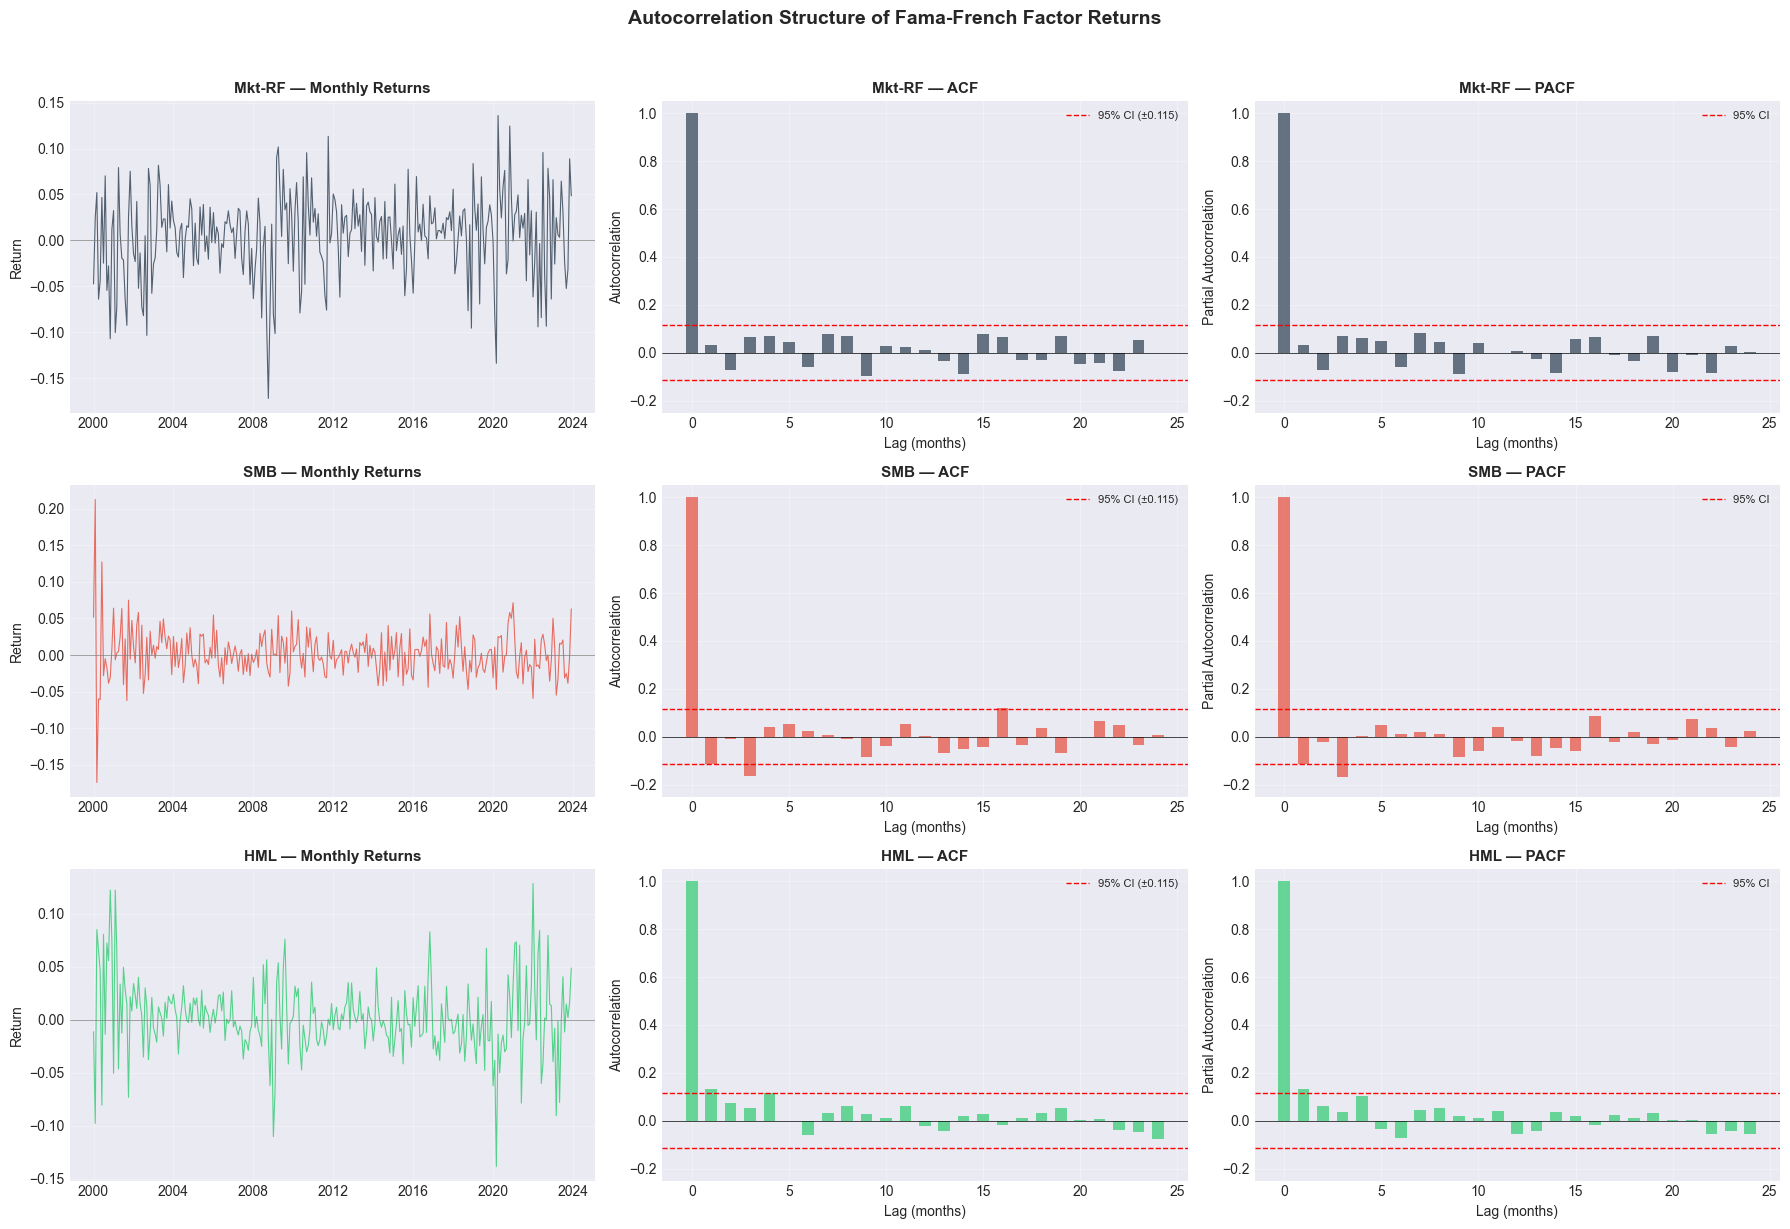

In [15]:
# ============================================================================
# Section 3: Autocorrelation analysis of Fama-French factor returns
# ============================================================================

fig, axes = plt.subplots(3, 3, figsize=(18, 12))

factors = ['Mkt-RF', 'SMB', 'HML']
colors = ['#2c3e50', '#e74c3c', '#2ecc71']
max_lags = 24

for i, (factor, color) in enumerate(zip(factors, colors)):
    series = ff3[factor].dropna()
    
    # --- Column 1: Time series ---
    ax = axes[i, 0]
    ax.plot(series.index, series.values, color=color, linewidth=0.8, alpha=0.8)
    ax.axhline(y=0, color='gray', linewidth=0.5)
    ax.set_title(f'{factor} — Monthly Returns', fontweight='bold', fontsize=11)
    ax.set_ylabel('Return')
    ax.grid(True, alpha=0.3)
    
    # --- Column 2: ACF ---
    ax = axes[i, 1]
    acf_vals = acf(series, nlags=max_lags, fft=True)
    conf_bound = 1.96 / np.sqrt(len(series))
    ax.bar(range(max_lags + 1), acf_vals, color=color, width=0.6, alpha=0.7)
    ax.axhline(y=conf_bound, color='red', linestyle='--', linewidth=1, label=f'95% CI (±{conf_bound:.3f})')
    ax.axhline(y=-conf_bound, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.set_title(f'{factor} — ACF', fontweight='bold', fontsize=11)
    ax.set_xlabel('Lag (months)')
    ax.set_ylabel('Autocorrelation')
    ax.legend(fontsize=8)
    ax.set_ylim(-0.25, 1.05)
    ax.grid(True, alpha=0.3)
    
    # --- Column 3: PACF ---
    ax = axes[i, 2]
    pacf_vals = pacf(series, nlags=max_lags, method='ywm')
    ax.bar(range(max_lags + 1), pacf_vals, color=color, width=0.6, alpha=0.7)
    ax.axhline(y=conf_bound, color='red', linestyle='--', linewidth=1, label=f'95% CI')
    ax.axhline(y=-conf_bound, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.set_title(f'{factor} — PACF', fontweight='bold', fontsize=11)
    ax.set_xlabel('Lag (months)')
    ax.set_ylabel('Partial Autocorrelation')
    ax.legend(fontsize=8)
    ax.set_ylim(-0.25, 1.05)
    ax.grid(True, alpha=0.3)

fig.suptitle('Autocorrelation Structure of Fama-French Factor Returns',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [16]:
# ============================================================================
# Ljung-Box tests for autocorrelation in returns
# ============================================================================

print("LJUNG-BOX TESTS FOR AUTOCORRELATION IN RETURNS")
print("=" * 70)
print("H0: No autocorrelation up to lag m")
print("H1: At least one autocorrelation is nonzero\n")

for factor in ['Mkt-RF', 'SMB', 'HML']:
    series = ff3[factor].dropna()
    print(f"--- {factor} ---")
    
    # Print first few autocorrelations
    acf_vals = acf(series, nlags=6, fft=True)
    print(f"  ACF lags 1-6: {', '.join(f'{a:.4f}' for a in acf_vals[1:7])}")
    
    # Ljung-Box at different lag horizons
    for m in [6, 12, 24]:
        lb = acorr_ljungbox(series, lags=m, return_df=True)
        q_stat = lb['lb_stat'].iloc[-1]
        p_val = lb['lb_pvalue'].iloc[-1]
        sig = '***' if p_val < 0.01 else '**' if p_val < 0.05 else '*' if p_val < 0.10 else ''
        print(f"  Q({m:2d}) = {q_stat:8.3f},  p-value = {p_val:.4f} {sig}")
    print()

print("INTERPRETATION:")
print("- Mkt-RF: Individual autocorrelations are tiny. Ljung-Box may or may")
print("  not reject — even small autocorrelations can be jointly significant.")
print("- SMB and HML: May show slightly more autocorrelation (factor portfolios")
print("  are rebalanced less frequently than individual stocks).")
print("\nEven when autocorrelation is small, Newey-West corrects for it.")
print("The key insight: returns are NEARLY uncorrelated but NOT independent.")

LJUNG-BOX TESTS FOR AUTOCORRELATION IN RETURNS
H0: No autocorrelation up to lag m
H1: At least one autocorrelation is nonzero

--- Mkt-RF ---
  ACF lags 1-6: 0.0338, -0.0708, 0.0653, 0.0691, 0.0435, -0.0617
  Q( 6) =    6.134,  p-value = 0.4083 
  Q(12) =   12.540,  p-value = 0.4033 
  Q(24) =   24.560,  p-value = 0.4300 

--- SMB ---
  ACF lags 1-6: -0.1121, -0.0087, -0.1623, 0.0395, 0.0515, 0.0238
  Q( 6) =   12.800,  p-value = 0.0463 **
  Q(12) =   16.249,  p-value = 0.1801 
  Q(24) =   28.101,  p-value = 0.2558 

--- HML ---
  ACF lags 1-6: 0.1304, 0.0757, 0.0543, 0.1151, -0.0029, -0.0603
  Q( 6) =   12.470,  p-value = 0.0523 *
  Q(12) =   15.426,  p-value = 0.2190 
  Q(24) =   20.662,  p-value = 0.6586 

INTERPRETATION:
- Mkt-RF: Individual autocorrelations are tiny. Ljung-Box may or may
  not reject — even small autocorrelations can be jointly significant.
- SMB and HML: May show slightly more autocorrelation (factor portfolios
  are rebalanced less frequently than individual sto

---

## Section 4: Volatility Clustering — The Hidden Dependence

### 4.1 The Key Distinction: Uncorrelated ≠ Independent

Section 3 showed that factor returns have very weak autocorrelation: $\hat{\rho}_k \approx 0$ for all $k \geq 1$. A naive conclusion might be: "Returns are independent, so the classical CLT applies and we don't need Newey-West."

This would be **wrong**.

**Uncorrelated** means $\text{Cov}(X_t, X_{t+k}) \approx 0$ — there is no *linear* dependence between returns at different times. But **independent** means *no dependence of any kind* — not even in higher moments.

The crucial observation: while $\text{Corr}(X_t, X_{t+k}) \approx 0$, we typically see:

$$\text{Corr}(X_t^2, X_{t+k}^2) \gg 0 \qquad \text{and} \qquad \text{Corr}(|X_t|, |X_{t+k}|) \gg 0$$

Large returns (of either sign) tend to be followed by large returns, and small returns by small returns. This is **volatility clustering** — the variance of returns changes over time in a persistent way.

### 4.2 Conditional vs. Unconditional Variance

This introduces a distinction that is crucial for understanding when standard errors need correction:

- **Unconditional variance**: $\text{Var}(X_t) = \gamma_0$ — a single number, constant over time (by stationarity)
- **Conditional variance**: $\text{Var}(X_t \mid X_{t-1}, X_{t-2}, \ldots) = \sigma_t^2$ — varies over time, depending on recent history

A GARCH(1,1) model makes this explicit:

$$\sigma_t^2 = \omega + \alpha X_{t-1}^2 + \beta \sigma_{t-1}^2$$

Even though $\sigma_t^2$ fluctuates period-to-period, its long-run average $E[\sigma_t^2] = \omega / (1 - \alpha - \beta)$ is constant. So the series is still *weakly stationary* — the unconditional variance exists — but the conditional variance changes.

### 4.3 Why This Matters for Standard Errors

Volatility clustering creates **conditional heteroscedasticity** — the variance of the error terms in a regression changes over time, even if it is stationary in the unconditional sense.

This violates the "constant variance" assumption of classical OLS. The consequences:

| | OLS coefficients ($\hat{\beta}$) | Classic standard errors | Newey-West standard errors |
|-|----------------------------------|------------------------|---------------------------|
| Affected? | **No** — OLS is still unbiased and consistent | **Yes** — can be too small or too large | **No** — designed for this |

OLS coefficients remain valid (unbiased, consistent) regardless of heteroscedasticity. But the standard errors — and therefore the t-statistics, p-values, and confidence intervals — can be badly wrong with classic OLS. This is exactly what heteroscedasticity-consistent (HC) and HAC (Newey-West) standard errors fix.

### 4.4 The ARCH Test

To formally test for volatility clustering, we use **Engle's ARCH test** (1982). The idea is simple: regress the squared residuals $\hat{\epsilon}_t^2$ on their own lags:

$$\hat{\epsilon}_t^2 = \alpha_0 + \alpha_1 \hat{\epsilon}_{t-1}^2 + \cdots + \alpha_p \hat{\epsilon}_{t-p}^2 + u_t$$

and test $H_0: \alpha_1 = \cdots = \alpha_p = 0$ (no ARCH effects, i.e. constant conditional variance).

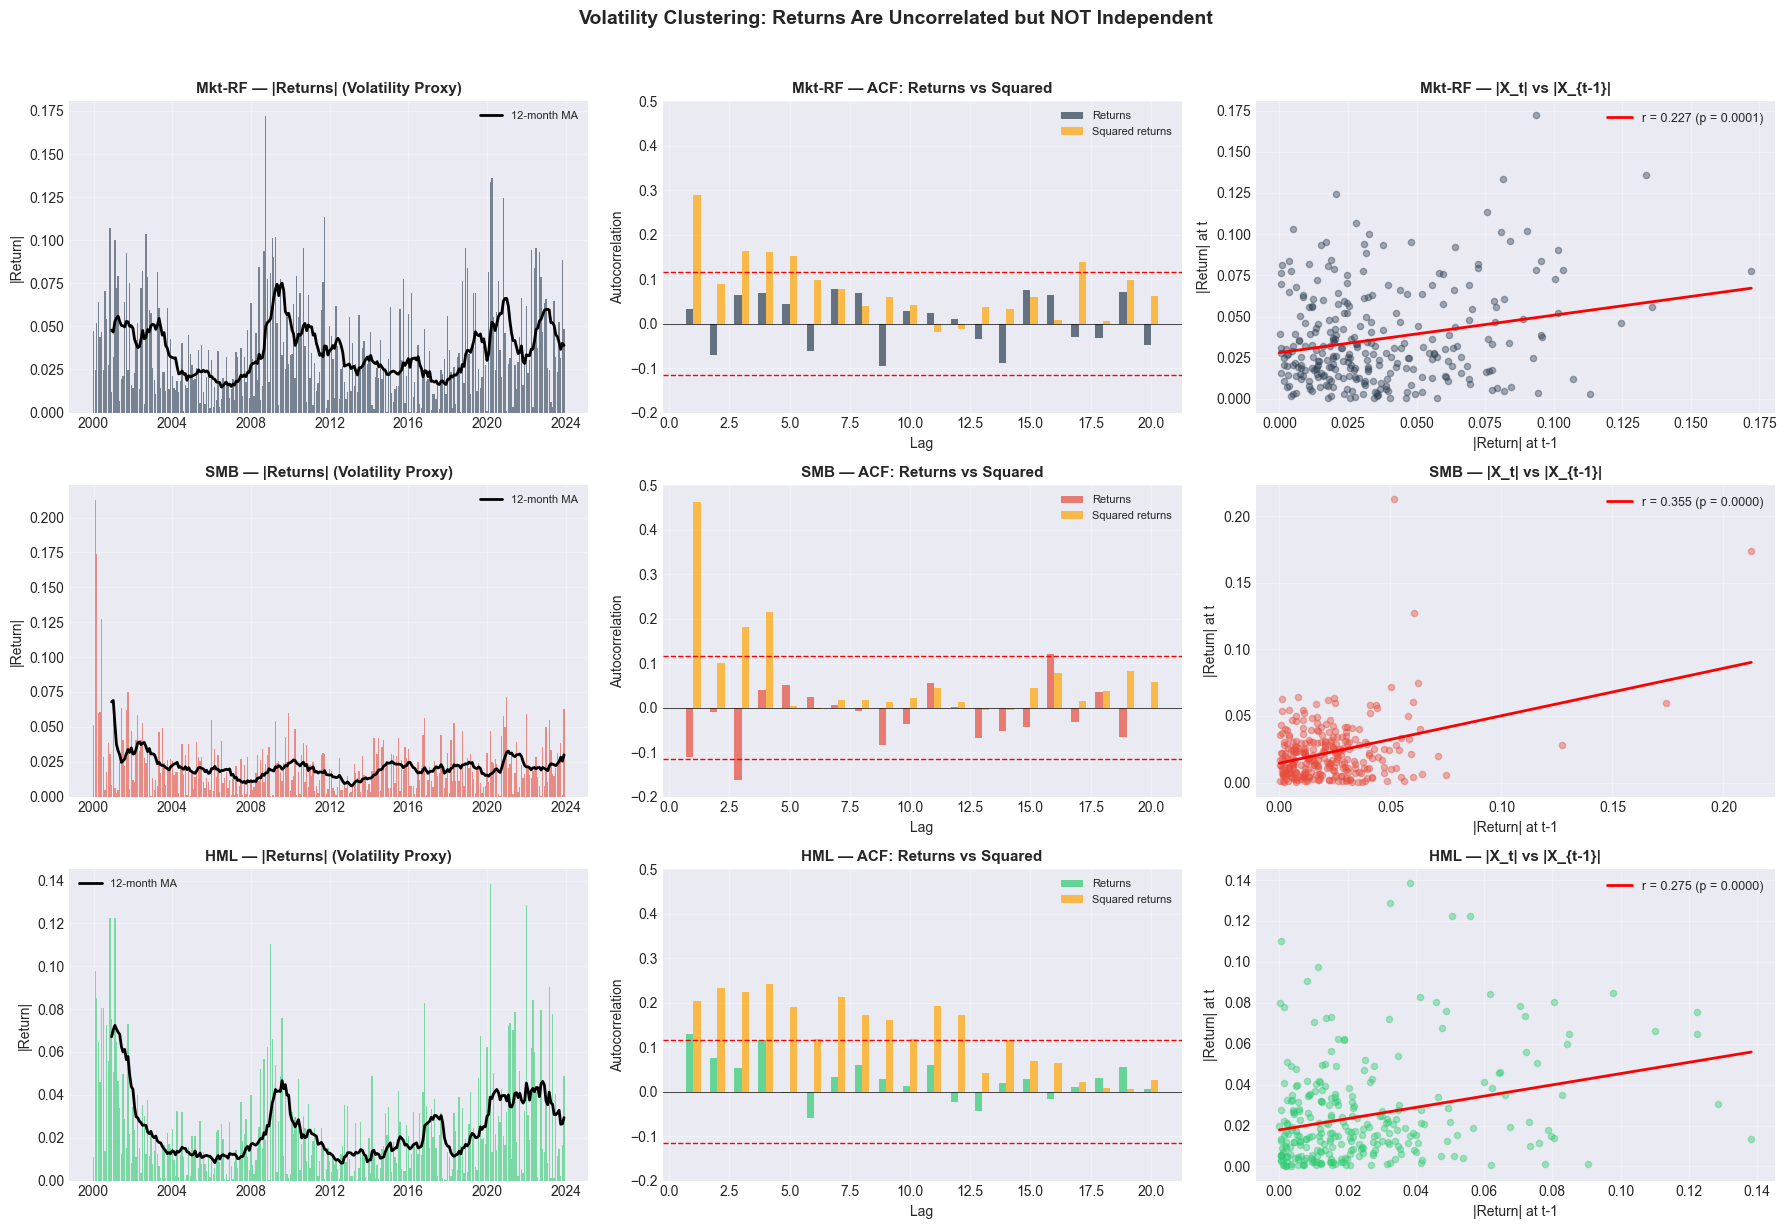

KEY FINDING:
- Left column: Absolute returns cluster — volatile periods are followed by volatile periods.
- Middle column: Returns themselves have near-zero ACF, but SQUARED returns are
  strongly autocorrelated. This is the signature of volatility clustering.
- Right column: |X_t| and |X_{t-1}| are positively correlated — large moves
  predict large moves (of either sign).

This is why UNCORRELATED ≠ INDEPENDENT, and why Newey-West is needed.


In [17]:
# ============================================================================
# Section 4: Volatility clustering — the smoking gun
# ============================================================================

fig, axes = plt.subplots(3, 3, figsize=(18, 12))

factors = ['Mkt-RF', 'SMB', 'HML']
colors = ['#2c3e50', '#e74c3c', '#2ecc71']

for i, (factor, color) in enumerate(zip(factors, colors)):
    series = ff3[factor].dropna()
    sq_series = series ** 2
    abs_series = series.abs()
    
    # --- Column 1: Absolute returns (shows clustering visually) ---
    ax = axes[i, 0]
    ax.bar(series.index, abs_series.values, color=color, width=25, alpha=0.6)
    ax.plot(series.index, abs_series.rolling(12).mean().values, color='black',
            linewidth=2, label='12-month MA')
    ax.set_title(f'{factor} — |Returns| (Volatility Proxy)', fontweight='bold', fontsize=11)
    ax.set_ylabel('|Return|')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # --- Column 2: ACF of returns (should be near zero) ---
    ax = axes[i, 1]
    acf_ret = acf(series, nlags=20, fft=True)
    acf_sq = acf(sq_series, nlags=20, fft=True)
    conf = 1.96 / np.sqrt(len(series))
    lags = np.arange(1, 21)
    ax.bar(lags - 0.15, acf_ret[1:21], width=0.3, color=color, alpha=0.7, label='Returns')
    ax.bar(lags + 0.15, acf_sq[1:21], width=0.3, color='orange', alpha=0.7, label='Squared returns')
    ax.axhline(y=conf, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=-conf, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.set_title(f'{factor} — ACF: Returns vs Squared', fontweight='bold', fontsize=11)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.legend(fontsize=8)
    ax.set_ylim(-0.2, 0.5)
    ax.grid(True, alpha=0.3)
    
    # --- Column 3: Scatter of |X_t| vs |X_{t-1}| ---
    ax = axes[i, 2]
    ax.scatter(abs_series.iloc[:-1].values, abs_series.iloc[1:].values,
              alpha=0.4, s=20, color=color)
    # Fit a line
    slope, intercept, r, p, se = stats.linregress(abs_series.iloc[:-1], abs_series.iloc[1:])
    x_line = np.linspace(0, abs_series.max(), 100)
    ax.plot(x_line, intercept + slope * x_line, 'r-', linewidth=2,
            label=f'r = {r:.3f} (p = {p:.4f})')
    ax.set_title(f'{factor} — |X_t| vs |X_{{t-1}}|', fontweight='bold', fontsize=11)
    ax.set_xlabel('|Return| at t-1')
    ax.set_ylabel('|Return| at t')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

fig.suptitle('Volatility Clustering: Returns Are Uncorrelated but NOT Independent',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("KEY FINDING:")
print("- Left column: Absolute returns cluster — volatile periods are followed by volatile periods.")
print("- Middle column: Returns themselves have near-zero ACF, but SQUARED returns are")
print("  strongly autocorrelated. This is the signature of volatility clustering.")
print("- Right column: |X_t| and |X_{t-1}| are positively correlated — large moves")
print("  predict large moves (of either sign).")
print("\nThis is why UNCORRELATED ≠ INDEPENDENT, and why Newey-West is needed.")

In [18]:
# ============================================================================
# Formal ARCH test for conditional heteroscedasticity
# ============================================================================
from statsmodels.stats.diagnostic import het_arch

print("ENGLE'S ARCH TEST FOR CONDITIONAL HETEROSCEDASTICITY")
print("=" * 65)
print("H0: No ARCH effects (constant conditional variance)")
print("H1: ARCH effects present (volatility clustering)\n")

print(f"{'Factor':<12} {'Lags':>6} {'LM Stat':>10} {'p-value':>10} {'Result':>16}")
print("-" * 65)

for factor in ['Mkt-RF', 'SMB', 'HML']:
    series = ff3[factor].dropna().values
    for nlags in [1, 6, 12]:
        lm_stat, lm_pval, fstat, f_pval = het_arch(series, nlags=nlags)
        sig = 'ARCH effects ***' if lm_pval < 0.01 else 'ARCH effects **' if lm_pval < 0.05 else 'ARCH effects *' if lm_pval < 0.10 else 'No ARCH effects'
        print(f"{factor:<12} {nlags:>6} {lm_stat:>10.3f} {lm_pval:>10.4f} {sig:>16}")
    print()

print("INTERPRETATION:")
print("- Mkt-RF shows strong ARCH effects at all lag lengths — market volatility clusters heavily.")
print("- SMB shows very strong short-lag ARCH effects (lag 1), but these may attenuate at")
print("  longer lag horizons — suggesting shorter-lived volatility dynamics for the size factor.")
print("- HML shows persistent ARCH effects across all lags.")
print("\nAll three factors exhibit conditional heteroscedasticity — the formal evidence that")
print("CLASSIC OLS standard errors are invalid for financial time series, even when return")
print("autocorrelation is negligible. Heteroscedasticity-consistent (HC) or HAC (Newey-West)")
print("standard errors are required.")

ENGLE'S ARCH TEST FOR CONDITIONAL HETEROSCEDASTICITY
H0: No ARCH effects (constant conditional variance)
H1: ARCH effects present (volatility clustering)

Factor         Lags    LM Stat    p-value           Result
-----------------------------------------------------------------
Mkt-RF            1     24.151     0.0000 ARCH effects ***
Mkt-RF            6     33.285     0.0000 ARCH effects ***
Mkt-RF           12     36.849     0.0002 ARCH effects ***

SMB               1     61.711     0.0000 ARCH effects ***
SMB               6      7.854     0.2490  No ARCH effects
SMB              12     24.627     0.0167  ARCH effects **

HML               1     11.883     0.0006 ARCH effects ***
HML               6     34.657     0.0000 ARCH effects ***
HML              12     34.970     0.0005 ARCH effects ***

INTERPRETATION:
- Mkt-RF shows strong ARCH effects at all lag lengths — market volatility clusters heavily.
- SMB shows very strong short-lag ARCH effects (lag 1), but these may attenuat

### 4.5 From ARCH to GARCH(1,1): Modelling Volatility Dynamics

The ARCH test tells us volatility clustering *exists*, but it does not tell us how to model it. The **GARCH(1,1)** model (Bollerslev, 1986) is the workhorse specification:

$$r_t = \mu + \epsilon_t, \qquad \epsilon_t = \sigma_t z_t, \qquad z_t \sim \mathcal{N}(0,1)$$

$$\sigma_t^2 = \omega + \alpha\, \epsilon_{t-1}^2 + \beta\, \sigma_{t-1}^2$$

where:
- $\sigma_t^2$ is the **conditional variance** at time $t$ (the variance you would forecast *given* information up to $t-1$)
- $\omega > 0$ is a constant (long-run intercept)
- $\alpha \geq 0$ captures the **shock impact**: a large $|\epsilon_{t-1}|$ (yesterday's surprise) raises today's variance
- $\beta \geq 0$ captures **persistence**: today's variance inherits a fraction of yesterday's variance
- Stationarity requires $\alpha + \beta < 1$

**Why does this matter for Fama-French regressions?**

1. **OLS coefficients are still unbiased and consistent** — GARCH affects the *error variance*, not the expected value of the errors.
2. **Classic standard errors are wrong** — they assume $\text{Var}(\epsilon_t) = \sigma^2$ (constant). Since $\sigma_t^2$ fluctuates, classic SEs are biased.
3. **Newey-West fixes this** — the HAC estimator allows each $\hat{\epsilon}_t^2$ to differ (the "heteroscedasticity" part of "HAC"), so GARCH-type patterns do not invalidate inference.
4. **Unconditional variance still exists** — if $\alpha + \beta < 1$, the unconditional variance is $\sigma^2_{\text{unc}} = \omega / (1 - \alpha - \beta)$, and the process is strictly stationary. This is why GARCH returns satisfy the mixing condition (Section 5).

**Typical estimates for monthly US equity returns:** $\alpha \approx 0.05\text{–}0.15$, $\beta \approx 0.80\text{–}0.92$, with $\alpha + \beta \approx 0.95\text{–}0.99$ — high persistence but strictly below 1.

> **Note:** We do not fit a GARCH model here because our goal is running Fama-French regressions, not forecasting volatility. The key insight is that GARCH-type dynamics are present (confirmed by the ARCH test above), they violate the homoscedasticity assumption, and Newey-West handles this without needing to specify the volatility process explicitly.

---

## Section 5: Ergodicity and Mixing — Why a Single Time Path Is Enough

### 5.1 The Ergodicity Problem

Here is a deep conceptual issue that is often glossed over.

In cross-sectional statistics (e.g., polling 1,000 people), we have **many independent draws** from a population. The Law of Large Numbers and the CLT are straightforward: as the sample size grows, the sample mean converges to the population mean.

In time series, we have a **single realization** of the process. We observe the stock market from 2000 to 2023 — we cannot rewind history and observe it again under a different draw from the probability measure. We have $n = 288$ observations, but they all come from **one path**.

So why does $\bar{X}_n$ converge to $E[X_t]$? This is not obvious — the Law of Large Numbers was stated for independent draws.

### 5.2 Ergodicity: Time Averages = Ensemble Averages

A stationary process $\{X_t\}$ is **ergodic** if time averages converge to population averages:

$$\bar{X}_n = \frac{1}{n}\sum_{t=1}^n X_t \xrightarrow{a.s.} E[X_t] = \mu$$

and more generally, any function of $(X_t, X_{t+1}, \ldots, X_{t+k})$ has its time average converge to its expectation.

**Intuition:** If the process "forgets" its past quickly enough, then observations far apart in time are *effectively independent*, and we can treat them like multiple draws from the same distribution.

**Sufficient condition:** If the autocovariances satisfy $\sum_{k=0}^{\infty} |\gamma_k| < \infty$ (they decay fast enough to be absolutely summable), then the process is ergodic for the mean and the Mixing CLT (Section 3.5 of the Foundations tutorial) applies.

### 5.3 Mixing: How Fast Does Dependence Decay?

**Mixing conditions** formalize the idea that "the distant past and the distant future are approximately independent." A process is **$\alpha$-mixing** (strongly mixing) if:

$$\alpha(k) = \sup_{A \in \mathcal{F}_{-\infty}^0, B \in \mathcal{F}_k^{\infty}} |P(A \cap B) - P(A)P(B)| \to 0 \quad \text{as } k \to \infty$$

In words: events in the far past and events in the far future become independent. The rate at which $\alpha(k)$ decays determines which CLT version applies  and what lag length Newey-West needs.

**For financial returns:** The dependence in returns (small autocorrelation) and in squared returns (GARCH effects) both decay geometrically fast. This makes returns **strongly mixing** — comfortably satisfying the conditions needed for:

- The mixing CLT to apply (Section 3.5 of the Foundations tutorial)
- Newey-West standard errors to be consistent
- Time averages to converge to population quantities

### 5.4 What Could Go Wrong: Non-Ergodic Processes

Not all processes are ergodic. Important counterexamples:

| Process | Ergodic? | Problem |
|---------|----------|---------|
| **Random walk** ($P_t = P_{t-1} + \epsilon_t$) | No | Variance grows without bound; no stable mean to converge to |
| **Structural break** (mean shifts from $\mu_1$ to $\mu_2$ at unknown time $T^*$) | No | $\bar{X}_n$ converges to a weighted average of $\mu_1$ and $\mu_2$, not "the" mean |
| **Unit root in volatility** | No | Unconditional variance does not exist |
| **Stationary GARCH returns** | **Yes** | Conditional variance changes, but the process still forgets its past fast enough |

This is precisely why we test for stationarity (Section 2): it rules out the non-ergodic cases.

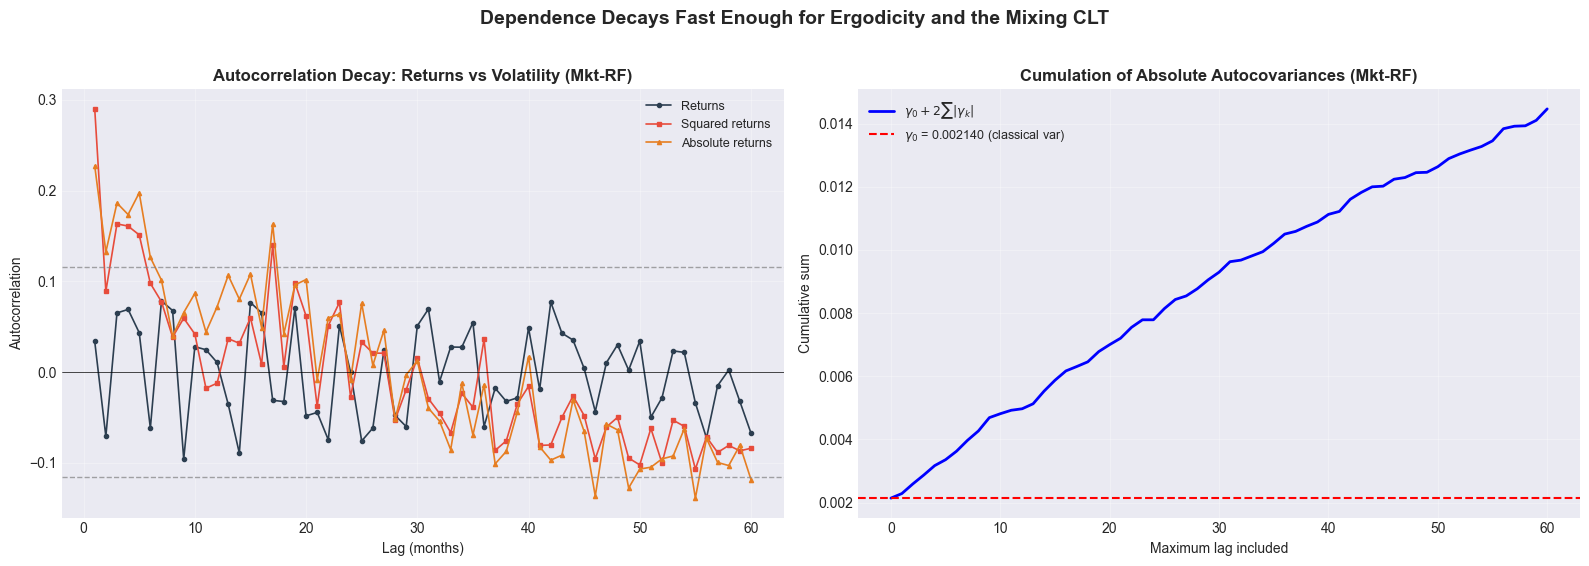

LEFT: Return autocorrelations are near zero and decay immediately.
Squared/absolute return autocorrelations are larger but still decay to zero — this
is the mixing property. The process forgets its past.

RIGHT: The cumulative sum of absolute autocovariances grows steeply at first
(reflecting genuine short-lag dependence in volatility) and then grows more slowly.
With only 288 monthly observations, the sum does not fully plateau because
sample autocovariances at high lags are noisy — even pure noise contributes
positive absolute values to the running total. Despite this, the *rate of growth*
slows markedly, consistent with the theoretical sum being finite.
The long-run variance (LRV) exceeds gamma_0 = 0.002140, which is the classical
variance. This gap between the LRV and gamma_0 is precisely what Newey-West captures.


In [19]:
# ============================================================================
# Section 5: Visualizing the decay of dependence (mixing)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5.5))

max_lag = 60
mkt = ff3['Mkt-RF'].dropna()

# --- Left: ACF of returns vs squared returns vs absolute returns ---
ax = axes[0]
acf_ret = acf(mkt, nlags=max_lag, fft=True)
acf_sq = acf(mkt**2, nlags=max_lag, fft=True)
acf_abs = acf(mkt.abs(), nlags=max_lag, fft=True)

lags = np.arange(1, max_lag + 1)
ax.plot(lags, acf_ret[1:], 'o-', color='#2c3e50', markersize=3, linewidth=1.2, label='Returns')
ax.plot(lags, acf_sq[1:], 's-', color='#e74c3c', markersize=3, linewidth=1.2, label='Squared returns')
ax.plot(lags, acf_abs[1:], '^-', color='#e67e22', markersize=3, linewidth=1.2, label='Absolute returns')
ax.axhline(y=1.96/np.sqrt(len(mkt)), color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.axhline(y=-1.96/np.sqrt(len(mkt)), color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_title('Autocorrelation Decay: Returns vs Volatility (Mkt-RF)', fontweight='bold', fontsize=12)
ax.set_xlabel('Lag (months)')
ax.set_ylabel('Autocorrelation')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Right: Cumulative sum of absolute autocovariances (for long-run variance) ---
ax2 = axes[1]
n_obs = len(mkt)
gamma_0 = mkt.var()
cum_abs_acov = [gamma_0]
for k in range(1, max_lag + 1):
    gamma_k = np.mean((mkt.values[k:] - mkt.mean()) * (mkt.values[:-k] - mkt.mean()))
    cum_abs_acov.append(cum_abs_acov[-1] + 2 * abs(gamma_k))

ax2.plot(range(max_lag + 1), cum_abs_acov, 'b-', linewidth=2, label='$\\gamma_0 + 2\\sum|\\gamma_k|$')
ax2.axhline(y=gamma_0, color='red', linestyle='--', linewidth=1.5, label=f'$\\gamma_0$ = {gamma_0:.6f} (classical var)')
ax2.set_title('Cumulation of Absolute Autocovariances (Mkt-RF)', fontweight='bold', fontsize=12)
ax2.set_xlabel('Maximum lag included')
ax2.set_ylabel('Cumulative sum')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

fig.suptitle('Dependence Decays Fast Enough for Ergodicity and the Mixing CLT',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("LEFT: Return autocorrelations are near zero and decay immediately.")
print("Squared/absolute return autocorrelations are larger but still decay to zero — this")
print("is the mixing property. The process forgets its past.\n")
print("RIGHT: The cumulative sum of absolute autocovariances grows steeply at first")
print("(reflecting genuine short-lag dependence in volatility) and then grows more slowly.")
print("With only 288 monthly observations, the sum does not fully plateau because")
print("sample autocovariances at high lags are noisy — even pure noise contributes")
print("positive absolute values to the running total. Despite this, the *rate of growth*")
print("slows markedly, consistent with the theoretical sum being finite.")
print(f"The long-run variance (LRV) exceeds gamma_0 = {gamma_0:.6f}, which is the classical")
print(f"variance. This gap between the LRV and gamma_0 is precisely what Newey-West captures.")

---

## Section 6: Summary — What Fama-French Regressions Actually Require

### 6.1 The Assumption Stack

When you run a Fama-French regression like:

$$R^e_{i,t} = \alpha_i + \beta_{i,1} \cdot \text{Mkt-RF}_t + \beta_{i,2} \cdot \text{SMB}_t + \beta_{i,3} \cdot \text{HML}_t + \epsilon_{i,t}$$

here is the full list of assumptions and which statistical results guarantee what:

| Assumption | What it means | Needed for | Tested by | Typically holds? |
|-----------|---------------|-----------|-----------|------------------|
| **Stationarity** | Statistical properties of returns don't drift over time | Everything — CLT, LLN, consistency of $\hat{\beta}$ | ADF test, visual inspection | **Yes** for returns (Section 2) |
| **Ergodicity** | Time averages converge to population quantities | Consistency of all estimators | Implied by stationarity + mixing | **Yes** (Section 5) |
| **Linearity** | True relationship between $R^e$ and factors is linear | Correct specification of $\hat{\beta}$ | Residual plots, Ramsey RESET | **Approximately** for monthly data |
| **No perfect multicollinearity** | Factors are not exact linear combinations of each other | $\mathbf{X}^T\mathbf{X}$ is invertible | VIF | **Yes** by construction |
| **$E[\epsilon_t \mid \mathbf{X}_t] = 0$** | Errors are mean-zero given the factors | Unbiasedness of OLS | Not directly testable; economic argument | **Assumed** (factor model) |
| **Homoscedasticity** | $\text{Var}(\epsilon_t) = \sigma^2$ constant | Classic OLS standard errors | Breusch-Pagan, ARCH test | **No** — volatility clusters (Section 4) |
| **No autocorrelation** | $\text{Cov}(\epsilon_t, \epsilon_s) = 0$ for $t \neq s$ | Classic OLS standard errors | Durbin-Watson, Ljung-Box | **Approximately** — mild autocorrelation possible |
| **Normality of errors** | $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$ | Exact finite-sample inference (t-tests, F-tests) | Jarque-Bera | **No** — fat tails (but CLT rescues us) |
| **Mixing / weak dependence** | Dependence between $\epsilon_t$ and $\epsilon_{t+k}$ decays | Newey-West consistency, mixing CLT | ACF of squared residuals | **Yes** (Section 5) |

### 6.2 What Holds, What Fails, and What Saves Us

**What holds comfortably:**
- Stationarity of returns ✓
- Ergodicity ✓
- No perfect multicollinearity ✓
- Mixing condition ✓

**What fails:**
- Homoscedasticity ✗ (volatility clustering → conditional heteroscedasticity)
- Normality ✗ (fat tails, occasional extreme returns)
- Strict independence ✗ (even if returns are uncorrelated, squared returns are autocorrelated)

**What saves us:**
- **The CLT** (in its mixing version, Section 3.5 of the Foundations tutorial): guarantees $\hat{\beta}$ is asymptotically normal, even without normality of errors.
- **Newey-West HAC standard errors**: correctly estimate the long-run variance $\sigma_{\text{LR}}^2$, accounting for both heteroscedasticity and autocorrelation.
- **Slutsky's theorem**: lets us plug in estimated variances without breaking the asymptotic normality.

### 6.3 The Bottom Line

The remarkable conclusion is that **very few assumptions need to hold exactly** for valid inference:

1. Returns must be **stationary** (they are)
2. Dependence must **decay over time** (it does — mixing condition)
3. We must use **the right standard errors** (Newey-West, not classic OLS)

Everything else — non-normality, volatility clustering, mild autocorrelation — is handled by the asymptotic theory. This is what makes modern financial econometrics work.

> **Reading forward:** The 3-Factor Tutorial uses Newey-West standard errors throughout and tests the classical assumptions as a diagnostic exercise (Section 8). Now you know *why* those classical tests often fail — and why it doesn't matter, as long as we use the right standard errors.

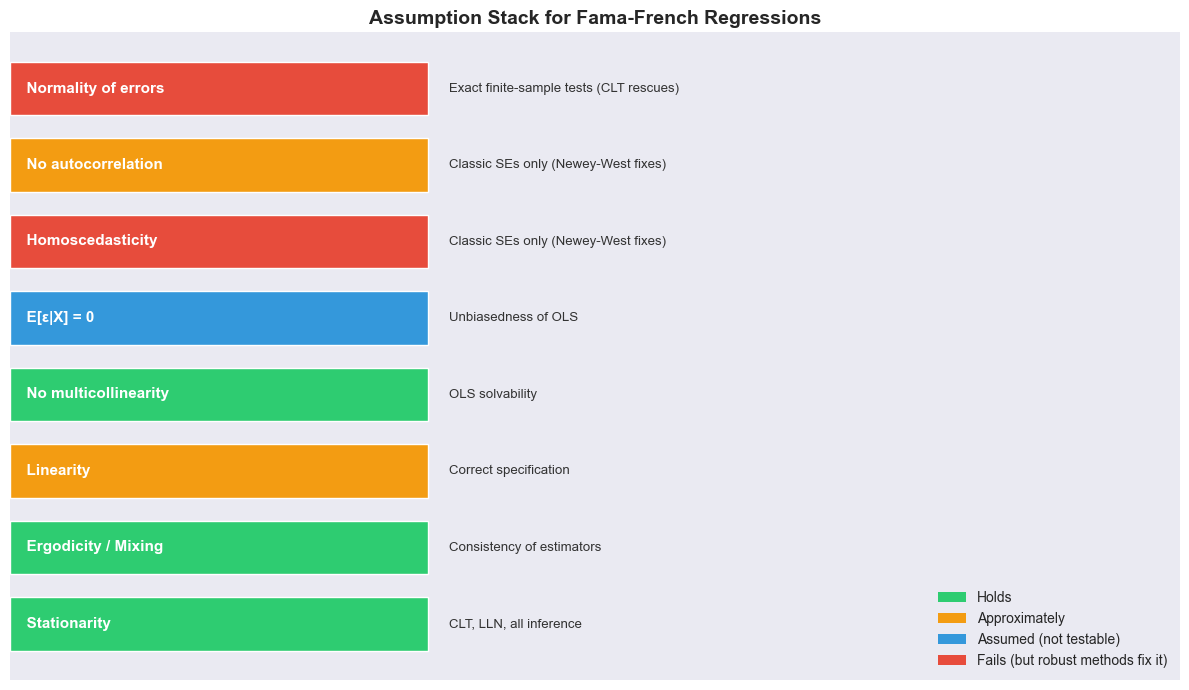

THE BOTTOM LINE:
- Green assumptions HOLD → standard tools work.
- Red assumptions FAIL → but Newey-West and the CLT rescue us.
- This is why every regression in the Fama-French tutorials uses Newey-West.


In [20]:
# ============================================================================
# Section 6: Summary visualization — the assumption stack
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 7))

assumptions = [
    'Stationarity',
    'Ergodicity / Mixing',
    'Linearity',
    'No multicollinearity',
    'E[ε|X] = 0',
    'Homoscedasticity',
    'No autocorrelation',
    'Normality of errors',
]

status = ['holds', 'holds', 'approx', 'holds', 'assumed', 'fails', 'approx', 'fails']
colors_map = {'holds': '#2ecc71', 'approx': '#f39c12', 'assumed': '#3498db', 'fails': '#e74c3c'}
bar_colors = [colors_map[s] for s in status]

needed_for = [
    'CLT, LLN, all inference',
    'Consistency of estimators',
    'Correct specification',
    'OLS solvability',
    'Unbiasedness of OLS',
    'Classic SEs only (Newey-West fixes)',
    'Classic SEs only (Newey-West fixes)',
    'Exact finite-sample tests (CLT rescues)',
]

y_pos = np.arange(len(assumptions))
bars = ax.barh(y_pos, [1]*len(assumptions), color=bar_colors, edgecolor='white', height=0.7)

for j, (assump, need, s) in enumerate(zip(assumptions, needed_for, status)):
    ax.text(0.02, j, f'  {assump}', va='center', fontsize=11, fontweight='bold', color='white')
    ax.text(1.05, j, need, va='center', fontsize=9.5, color='#333333')

ax.set_xlim(0, 2.8)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title('Assumption Stack for Fama-French Regressions', fontweight='bold', fontsize=14)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Holds'),
    Patch(facecolor='#f39c12', label='Approximately'),
    Patch(facecolor='#3498db', label='Assumed (not testable)'),
    Patch(facecolor='#e74c3c', label='Fails (but robust methods fix it)'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, framealpha=0.9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()

print("THE BOTTOM LINE:")
print("- Green assumptions HOLD → standard tools work.")
print("- Red assumptions FAIL → but Newey-West and the CLT rescue us.")
print("- This is why every regression in the Fama-French tutorials uses Newey-West.")

---

## Summary and Connection to the Other Tutorials

### What We Showed

| Section | Key Result |
|---------|------------|
| 1 | Prices are non-stationary; **returns** are (approximately) stationary — this is why all of financial econometrics works with returns |
| 2 | **Stationarity** means constant mean, variance, and autocovariance structure — it is the foundation for everything. ADF tests confirm returns are stationary. |
| 3 | Returns have very weak **autocorrelation** — consistent with near-market-efficiency. Ljung-Box tests formalize this. |
| 4 | **Volatility clustering** is strong: squared/absolute returns are highly autocorrelated. This means returns are *uncorrelated but not independent* — the key distinction that motivates robust standard errors. |
| 5 | Returns satisfy **mixing conditions** — dependence decays fast enough for ergodicity, the mixing CLT, and Newey-West to work. |
| 6 | The full **assumption stack** for Fama-French regressions: most assumptions hold, and the ones that fail (homoscedasticity, normality) are rescued by the CLT + Newey-West. |

### How This Connects

- **Statistical Foundations** (previous notebook): Gave you the CLT, OLS, and Newey-West machinery. Section 3.5 introduced the Mixing CLT *abstractly*. This notebook showed it *empirically*.
- **3-Factor Tutorial** (next notebook): Runs Fama-French regressions with Newey-West standard errors. Section 8 tests the classical assumptions (normality, homoscedasticity, autocorrelation) — now you understand *why* some tests fail and why that's okay.
- **Advanced Tutorial**: Extends to 5-factor, momentum, and rolling windows. The time-varying factor exposures in Section 7 (rolling betas) connect directly to the stationarity discussion here — rolling windows are a practical way to handle slowly-changing parameters.

### Key Takeaways for Practitioners

1. **Always use returns, never prices** — prices are non-stationary
2. **Test for stationarity** (ADF) before running any regression
3. **Expect volatility clustering** — it is ubiquitous in financial data
4. **Use Newey-West standard errors** — they handle both heteroscedasticity and autocorrelation
5. **Don't panic when normality tests fail** — the CLT ensures asymptotic normality of regression coefficients regardless
6. **Check that dependence decays** — if you suspect structural breaks or regime changes, consider sub-sample analysis or rolling windows

---

## Exercises

### Exercise 1: Stationarity on a New Series (Hands-On)

Download daily prices for any stock (e.g., AAPL) using `yfinance` and compute daily log returns.

1. Run the ADF test on **prices** and on **log returns**. Do the results match what we found for Fama-French factors?
2. Plot the rolling 60-day mean and standard deviation of log returns. Does the series look approximately stationary?

```python
# Starter code:
import yfinance as yf
data = yf.download('AAPL', start='2015-01-01', end='2023-12-31', progress=False)
prices = data['Close']
log_returns = np.log(prices / prices.shift(1)).dropna()
```

### Exercise 2: Interpreting ACF Plots (Conceptual)

Consider three processes:
- (A) White noise: $X_t \sim \text{i.i.d.}\ \mathcal{N}(0,1)$
- (B) AR(1): $X_t = 0.8 X_{t-1} + \epsilon_t$
- (C) Financial returns with GARCH volatility

For each, sketch (or describe) what you expect the ACF of $X_t$ and the ACF of $X_t^2$ to look like. Then explain why process (C) makes Newey-West necessary even though its return ACF looks similar to (A).

### Exercise 3: Effect of Sample Period on ARCH Tests (Hands-On)

1. Split the Fama-French Mkt-RF data into two sub-periods: 2000–2011 and 2012–2023.
2. Run the ARCH test (with 6 lags) on each sub-period separately.
3. Is volatility clustering stronger in one period than the other? Which period contains the 2008 crisis?

```python
# Starter code:
mkt_early = ff3['Mkt-RF'].loc[:'2011-12']
mkt_late  = ff3['Mkt-RF'].loc['2012-01':]
# Run het_arch() on each and compare LM statistics
```

### Exercise 4: Mixing Condition in Practice (Discussion)

1. The right panel of the ergodicity plot shows $\gamma_0 + 2\sum_{k=1}^{M} |\gamma_k|$ converging as $M$ grows. What would this plot look like for a **random walk** (non-stationary process)? Why?
2. In your own words, explain why a finite long-run variance is necessary for the Newey-West estimator to be consistent.
3. If an asset's returns exhibited a **structural break** (e.g., a regime change in volatility after 2020), would the mixing condition still hold over the full sample? What practical step could you take?